<a href="https://colab.research.google.com/github/kaiu85/stable-diffusion-workshop/blob/main/Deep_Dive/Dreambooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dreambooth fine-tuning for Stable Diffusion using d🧨ffusers 

This notebook shows how to "teach" Stable Diffusion a new concept via Dreambooth using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

![Dreambooth Example](https://dreambooth.github.io/DreamBooth_files/teaser_static.jpg)
_By using just 3-5 images you can teach new concepts to Stable Diffusion and personalize the model on your own images_ 

For a general introduction to the Stable Diffusion model please refer to this [notebook](https://colab.research.google.com/github/kaiu85/stable-diffusion-workshop/blob/main/stable_diffusion.ipynb).



## Initial setup

In [1]:
!pip install -qq diffusers==0.4.1 accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes

Log into your Huggingface account. Reminder: You can find your tokens here: https://huggingface.co/settings/tokens.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [3]:
#@title Import required libraries
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import bitsandbytes as bnb

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Settings for teaching your new concept

In [4]:
# We'll be again using the CompVis/stable-diffusion-v1-4 pretrained model
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

Upload the images of the new concept, which you want to teach stable-diffusion, to the Colab instance by opening the file explorer via the folder.png-icon on the left. Then you can upload files using the upload.png-icon.

Now change the ``image_names`` list in the next cell, so that it contains the names of the uploaded images. For this notebook to run without uploading images, we just download some images from the web and collect their filenames in this list.

In [5]:
!wget https://www.dropbox.com/s/8tw7xtgf3rrintu/kai1.jpeg
!wget https://www.dropbox.com/s/0lfixzo87o6mdlc/kai2.jpeg

image_names = [
'kai1.jpeg',
'kai2.jpeg'
]

--2022-11-18 22:25:49--  https://www.dropbox.com/s/8tw7xtgf3rrintu/kai1.jpeg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8tw7xtgf3rrintu/kai1.jpeg [following]
--2022-11-18 22:25:50--  https://www.dropbox.com/s/raw/8tw7xtgf3rrintu/kai1.jpeg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd7a4028a6b6519eb1d8b31ffe2.dl.dropboxusercontent.com/cd/0/inline/BxDDW-qI5EhecwtyZ1vKrbvyetkHP_U5me8nJCBZIeOmdiHiLoal2xeapj8qUDP9mR7gZNxKV-qBC29mbC_V_9Z8V1zjAXD9UcrbGn5Rs6ifp9hGbybMzHO2YbBMT7qo6yyg5oOH6sOVLmV100BWffOSIOQxVwRjyI0iSEI8T9dLjQ/file# [following]
--2022-11-18 22:25:50--  https://ucd7a4028a6b6519eb1d8b31ffe2.dl.dropboxusercontent.com/cd/0/inline/BxDDW-qI5EhecwtyZ1vKrbvyetkHP_U5me8nJCBZIeOmdiHiLoal2xeapj8qUDP9mR7gZNxKV-qBC29mbC_V_9

The next cell reads in the images, which you've just uploaded and converts them into the right format for the stable-diffusion model.

In [6]:
#Setup and check the images you have just added
import requests
import glob
from io import BytesIO

images = list(filter(None,[Image.open(image_name).convert("RGB") for image_name in image_names]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]


[None, None]

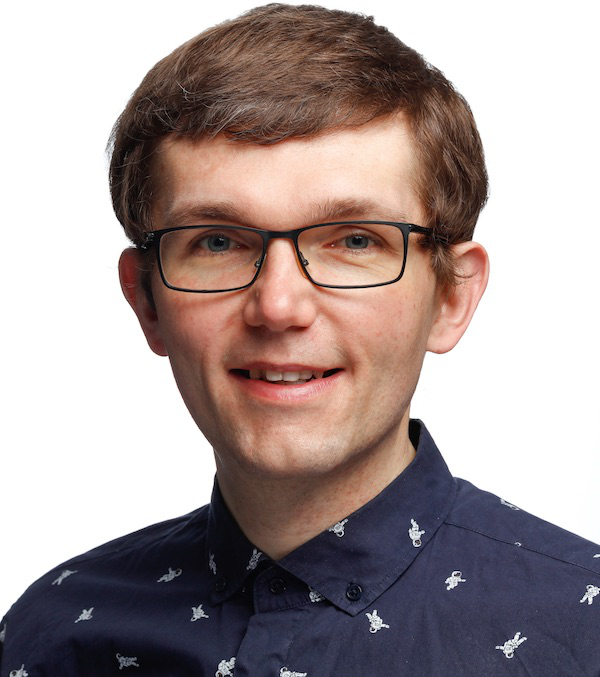

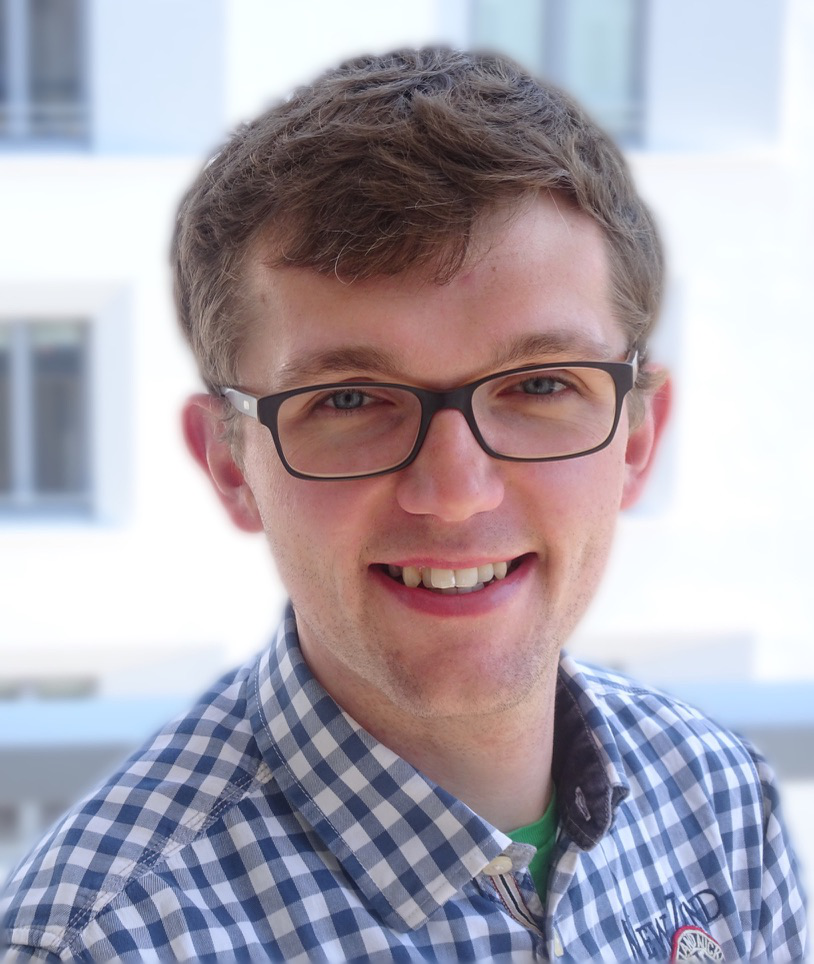

In [7]:
%matplotlib inline
for image in images:
  display(image)

To be able to generate images with the concept, which we are trying to teach the stable-diffusion model, we have to give this concept a **name**.
As this name, we use the special token associated with the letters ``sks``. In the next cell, we have to define a prompt, which fits all training images, and in which we also give the model some useful context cues, to **what exactly** ``sks`` is supposed to mean (it could be a person, a cat, a dog, a pet, a toy, an electric device, a car, a motorcycle, ...). As the template-images, which we've put online, all show a portrait photograph of a specific person, we use the prompt ``"a portrait photo of sks person"``. For stable-diffusion to learn and understand your own concept, make this prompt as informative as possible.

In [8]:
#Settings for your newly created concept
# `instance_prompt` is a prompt that should contain a good description of what 
# your object or style is, together with the initializer word `sks`  
instance_prompt = "a portrait photo of sks person"



"Prior preservation" is a technique, which prevents stable-diffusion from forgetting other concepts, while it tries to learn our new concept. It tremendously improves the quality of the generated images. However, it requires more memory than we have available on free Colab instances, so we don't use it today.


In [9]:
# We can't use prior preservation on a free Colab
# instance due to memory constraints.
prior_preservation = False

If you're running this on a larger instance, you can turn on prior preservation by setting the above variable to 'True'

Then you have to specify a prompt, which describes your training images well within the known classes of stable diffusion, i.e. without refering to the 'sks' token.


Prior preservation prevents 'overfitting' to your training data, by adding other images, which show the same class of object as your training image, but not the specific instance (i.e., pictures of the same breed of dog, same class of cars, ...).

You can either look for such pictures yourself, or just generate them from the stable-diffusion model. For this, you just have to give the model a prompt, which describes the specific class of object, to which the concept on your training images belongs.

Again, we cannot run this today, so feel free to just skip the next code cell, which collects all relevant parameters for prior preservation, just for the sake of completeness.

In [10]:
prior_preservation_class_prompt = "portrait photo of a man with glasses and brown hair"

num_class_images = 12 
sample_batch_size = 2
prior_loss_weight = 0.5
prior_preservation_class_folder = "./class_images"
class_data_root=prior_preservation_class_folder
class_prompt=prior_preservation_class_prompt
num_class_images = 12 
sample_batch_size = 2

# `prior_preservation_weight` determins how strong the class for 
# prior preservation should be 
prior_loss_weight = 1


# If the `prior_preservation_class_folder` is empty, images for the 
# class will be generated with the class prompt. 
# Otherwise, fill this folder with images of items on the same class as 
# your concept (but not images of the concept itself)
prior_preservation_class_folder = "./class_images" #
class_data_root=prior_preservation_class_folder

## Teach the model the new concept (fine-tuning with Dreambooth)
Execute this this sequence of cells to run the training process. The whole process may take from 15 min to 2 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

In [11]:
#@title Setup the Classes
from pathlib import Path
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids
        
        return example


class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

In [12]:
#@title Generate Class Images
import gc
if(prior_preservation):
    class_images_dir = Path(class_data_root)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < num_class_images:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path, revision="fp16", torch_dtype=torch.float16
        ).to("cuda")
        pipeline.enable_attention_slicing()
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = num_class_images - cur_class_images
        print(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size)

        for example in tqdm(sample_dataloader, desc="Generating class images"):
            images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")
        pipeline = None
        gc.collect()
        del pipeline
        with torch.no_grad():
          torch.cuda.empty_cache()

# Load the Stable Diffusion model
Please read and if you agree accept the LICENSE [here](https://huggingface.co/CompVis/stable-diffusion-v1-4) if you see an error

In [ ]:
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

In the next cell, we set up the training parameters. One of the most crucial parameters is the number of training steps. It should not be too few (150 likely are too few), so that stable-diffusion can learn the new concept, but it should also not be too many, so that stable-diffusion does not overfit to the new concept and starts to forget other concepts (600 likely are too many). So feel free to experiment with the ``max_train_steps``parameter.

In [ ]:
from argparse import Namespace
args = Namespace(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    resolution=512,
    center_crop=True,
    instance_data_dir=save_path,
    instance_prompt=instance_prompt,
    learning_rate=5e-06,
    max_train_steps=450,
    train_batch_size=1,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision="no", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation, 
    prior_loss_weight=prior_loss_weight,
    sample_batch_size=2,
    class_data_dir=prior_preservation_class_folder, 
    class_prompt=prior_preservation_class_prompt, 
    num_class_images=num_class_images, 
    output_dir="dreambooth-concept",
)

In [ ]:
#@title Training function
from accelerate.utils import set_seed
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
    )
    
    train_dataset = DreamBoothDataset(
        instance_data_root=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        # concat class and instance examples for prior preservation
        if args.with_prior_preservation:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt").input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch
    
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)
  
    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                if args.with_prior_preservation:
                    # Chunk the noise and noise_pred into two parts and compute the loss on each part separately.
                    noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
                    noise, noise_prior = torch.chunk(noise, 2, dim=0)

                    # Compute instance loss
                    loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                    # Compute prior loss
                    prior_loss = F.mse_loss(noise_pred_prior, noise_prior, reduction="none").mean([1, 2, 3]).mean()

                    # Add the prior loss to the instance loss.
                    loss = loss + args.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()
    
    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
#@title Run training
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
with torch.no_grad():
    torch.cuda.empty_cache()

## Run the code with your newly trained model
If you have just trained your model with the code above, use the block below to run it.

Also explore the [DreamBooth Concepts Library](https://huggingface.co/sd-dreambooth-library) 

In [ ]:
#@title Set up the pipeline 
try:
    pipe
except NameError:
    pipe = StableDiffusionPipeline.from_pretrained(
        args.output_dir,
        torch_dtype=torch.float16,
    ).to("cuda")

In [ ]:
#@title Run the Stable Diffusion pipeline on Colab

# IMPORTANT: Don't forget to use the 'sks' placeholder token in your prompt
prompt = "oil portrait of sks person"

num_samples = 2 # how many samples should be generated simultaneously
num_rows = 2 # how often should this number of samples be generated

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid